In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [75]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.75 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
data, all_gdps, all_gts = load_data()

print(f"Data shape: {data.shape}")

Data shape: (550, 97)


In [122]:
preprocessor = Preprocessing(data=data, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, shuffle=True)

X_train[preprocessor.country_train == "Switzerland"].head()

X_train shape : (391, 104)
X_valid shape : (131, 104)
y_train shape : (391,)
y_valid shape : (131,)


,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,Credit_average,...,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States,month_3,month_6,month_9,month_12
75,-0.364476,-1.631263,-1.773992,0.716809,-1.089976,1.362838,-0.620627,1.205726,-1.506236,1.041697,...,-0.41258,-0.351066,-0.441835,2.494951,-0.395479,-0.42939,1.0,0.0,0.0,0.0
436,0.789027,-1.564845,0.783413,0.259211,1.018556,1.769572,-0.620627,1.399548,0.379991,0.691479,...,-0.41258,-0.351066,-0.441835,2.494951,-0.395479,-0.42939,1.0,0.0,0.0,0.0
155,0.159844,-1.432009,0.522453,0.651438,-0.627127,0.286189,-0.620627,0.559654,-0.418028,0.954142,...,-0.41258,-0.351066,-0.441835,2.494951,-0.395479,-0.42939,1.0,0.0,0.0,0.0
307,1.156051,-1.365592,1.044372,0.618753,0.092859,-0.527280,-0.620627,0.042796,-0.200386,1.523246,...,-0.41258,-0.351066,-0.441835,2.494951,-0.395479,-0.42939,0.0,1.0,0.0,0.0
55,-0.679068,-1.432009,-1.773992,1.272465,-1.244259,-0.742610,-0.620627,1.270334,-1.361141,1.129251,...,-0.41258,-0.351066,-0.441835,2.494951,-0.395479,-0.42939,0.0,1.0,0.0,0.0


In [123]:
x_train = X_train.values
x_valid = X_valid.values
y_train = y_train.values
y_valid = y_valid.values
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

## Simple Prediction Model

### We start with a simple regression model

In [124]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [125]:
def spectral_norm(module, lip):
    if isinstance(module, nn.Linear):
        with torch.no_grad():
            # Compute the largest singular value (spectral norm) of the weight matrix
            sigma = torch.linalg.norm(module.weight, ord=2)
            # Scale the weight matrix to have spectral norm equal to 'lip'
            if sigma > EPS:
                scaling_factor = lip / sigma
                module.weight.mul_(scaling_factor)

# Inspired by https://arxiv.org/abs/1805.10408
def other_spectral_norm(module, lip):
    if isinstance(module, nn.Linear):
        with torch.no_grad():
            # Perform FFT on the kernel (channels-first format expected in PyTorch)
            transform_coefficients = torch.fft.fft2(module.weight, dim=[-2, -1])

            sigma = torch.linalg.norm(transform_coefficients, ord=2)

            # Scale the weight matrix to have spectral norm equal to 'lip'
            if sigma > EPS:
                scaling_factor = lip / sigma
                clipped_transform_coefficients = transform_coefficients * scaling_factor
                clipped_weights = torch.fft.ifft2(clipped_transform_coefficients, dim=[-2, -1]).real

                # Adjust the clipped kernel to match the original kernel shape
                module.weight.data = clipped_weights[:module.weight.shape[0], :module.weight.shape[1]]


def enforce_lipschitz(model, lip):
    model.apply(lambda x: other_spectral_norm(x, lip))

In [126]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 100),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=1000, learning_rate=1e-3, weight_decay=1e-4, lipschitz=None):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)
    
    training_loss = []
    validation_loss = []
    
    for t in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if lipschitz is not None:
            enforce_lipschitz(model, lipschitz)
        
    model.eval()
    y_pred = model(x_valid_t)
    loss = loss_fn(y_pred, y_valid_t)
    print(f"Validation loss: {loss.item()}")
    
    return model, training_loss, validation_loss, y_pred

In [127]:
def smoothness_measure(sequence, real_sequence):
    with torch.no_grad():
        diff_diff = torch.diff(sequence.squeeze()) - torch.diff(real_sequence.squeeze())
        return (torch.linalg.norm(diff_diff) / diff_diff.shape[0]).clone().detach().cpu().numpy()

In [134]:
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)
l = 35

model, training_loss, validation_loss, y_pred = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-5, lipschitz=l)

smoothness = smoothness_measure(y_pred, y_valid_t)

print(f"Lipschitz: {l}, Loss: {validation_loss[-1]}, Smoothness: {smoothness}")

C:\Users\sebge\AppData\Local\Temp\ipykernel_22164\2901282003.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\sebge\AppData\Local\Temp\ipykernel_22164\2901282003.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)


  0%|          | 0/2000 [00:00<?, ?it/s]

Validation loss: 0.8063839077949524
Lipschitz: 35, Loss: 0.8024951219558716, Smoothness: 0.10485714673995972


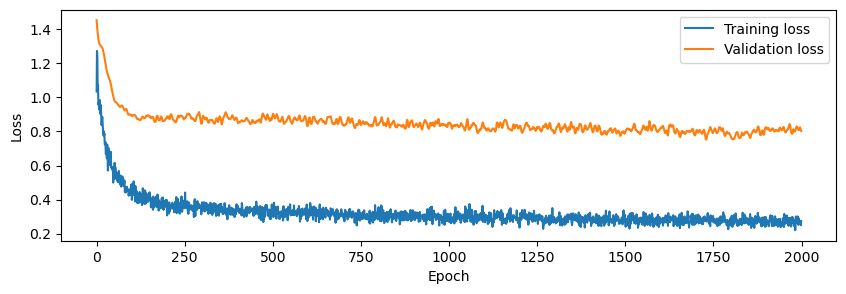

In [135]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [136]:
# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

C:\Users\sebge\AppData\Local\Temp\ipykernel_22164\470602592.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
C:\Users\sebge\AppData\Local\Temp\ipykernel_22164\470602592.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)


In [137]:
# Associate the result by country
y_pred_country = pd.DataFrame({'date': preprocessor.dates_valid, 'country': country_valid, 'y_pred': y_pred, 'y_true': y_valid})
y_pred_train_country = pd.DataFrame({'date': preprocessor.dates_train, 'country': country_train, 'y_pred': y_pred_train, 'y_true': y_train})
y_pred_train_country

,date,country,y_pred,y_true
434,2021-03-01,United Kingdom,-1.469516,-2.012738
440,2021-03-01,Japan,-0.775000,-0.621272
6,2005-06-01,Korea,0.334464,0.445068
184,2012-03-01,United States,-0.133369,0.043322
78,2008-06-01,Korea,0.495583,0.258364
...,...,...,...,...
27,2006-03-01,United Kingdom,0.461476,0.634040
407,2020-03-01,Switzerland,-0.395989,-0.395501
230,2013-09-01,United Kingdom,0.019049,0.135392
260,2014-12-01,Canada,-0.328015,-0.676543


In [138]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [139]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)



# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('United Kingdom', 'Japan', 'Korea', 'United St…